In [1]:
import time
import random
import math
import array
import pandas as pd
import numpy as np
import pyvisa as visa
import os
#from threading import Thread 
from AutoCircleCopyRS import move_circle
from move_by_XY import moveXY
from CenterPiezoRS import center_piezo
from GrabLocation import grab_location
#from BlasterDatacollection import dataB
from Movements import move_negB,move_posB,move_negA,move_posA

<IPython.core.display.Javascript object>

In [2]:
points = input('Enter number of points:')
trials = input('Enter number of trials allowed:')
name = '\AutoXYTest'
t = time.localtime()
current_time = time.strftime('_%Y%m%d_%H%M%S', t)
name = name+current_time
print(name)
folder = '.\Results'
os.mkdir(folder+name)
fulllist = name+'\FullList'
winlist = name+'\WinList'
print(fulllist)
x = 0
y = 0

Enter number of points:20
Enter number of trials allowed:10
\AutoXYTest_20230130_124000
\AutoXYTest_20230130_124000\FullList


In [3]:
#generate random movetable
i = 1
randxs = []
randys = []

while i <= int(points):
    circle_x = 10.389964222177706 
    circle_y = 7.4256552547346315   
    circle_r = 2
    alpha = 2 * math.pi * random.random() #random angle
    r = circle_r * math.sqrt(random.random()) #random radius
    randx = r * math.cos(alpha) + circle_x #calculating coordinates
    randy = r * math.sin(alpha) + circle_y
    #print("Random point", (randx, randy))
    randxs.append(randx)
    #print('Random x:',randxs)
    randys.append(randy)
    #print('Random y:',randys)
    
    i += 1
else:
    print('Random x:',randxs)
    print('Random y:',randys)

Random x: [9.370245458094093, 11.700285153252286, 9.02970803423778, 10.591365654793538, 10.579186816878034, 8.922864784148334, 11.40629662339548, 10.70634300322302, 9.483182890388889, 12.025030613266225, 11.196207090543485, 11.728231110375065, 11.060997751785285, 8.8370693037022, 9.03340837911605, 10.254890047988265, 10.204049455072171, 11.75502779773949, 11.354134466146562, 9.104358556039855]
Random y: [8.5651798787013, 6.373911984675784, 7.030293765929179, 8.316006369138446, 8.313034942628047, 8.36504897936611, 8.965053540589338, 8.417792147006729, 6.425866558122561, 8.437827143665722, 8.234528960223786, 6.675266634327368, 7.894984689997178, 6.509147980542688, 6.035764275913496, 5.6474886785588065, 9.216756369543113, 7.982652632378767, 7.4254914070566524, 6.825238157723239]


<IPython.core.display.Javascript object>

,original_pos_xy,Final_pos_xy,max_xy,min_xy,Radius_x,Radius_y,Area
0,"(10.507499999999999, 7.240499999999999)","([10.4895], [7.222499999999999])","(10.507499999999999, 7.240499999999999)","(10.4895, 7.222499999999999)",0.009,0.009,0.02826


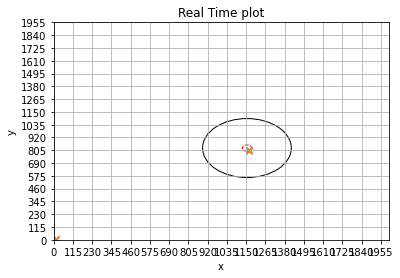

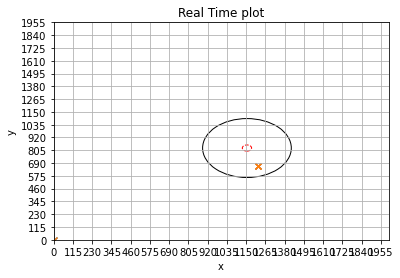

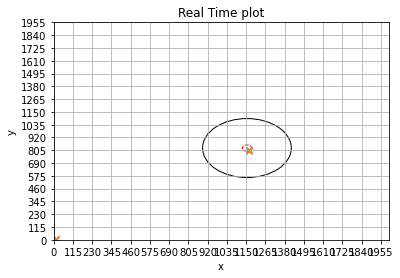

In [4]:
n = 1 #start at trial 1
i = 1 #start at point 1
w = 0 #start at zero wins
x,y = grab_location(_)
#center_piezo()
moveXY(circle_x-x,circle_y-y) #send the piezo back to the center
x,y = grab_location(fulllist)

<IPython.core.display.Javascript object>

,original_pos_xy,Final_pos_xy,max_xy,min_xy,Radius_x,Radius_y,Area
0,"(12.442499999999999, 6.403499999999999)","([12.4515], [6.3945])","(12.4515, 6.403499999999999)","(12.442499999999999, 6.3945)",0.0045,0.0045,0.007065


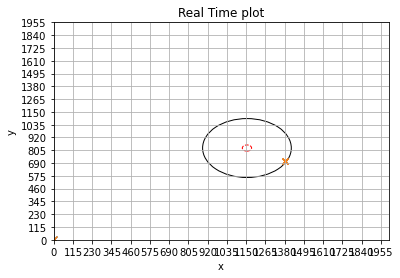

Trying this point again...Trial # 3
Point # 2
('USB0::0x2A8D::0x0387::CN61022130::0::INSTR', 'USB0::0xF4ED::0xEE3A::388C14124::0::INSTR', 'TCPIP0::K-34465A-15446::hislip0::INSTR', 'TCPIP0::K-34465A-15446::inst0::INSTR', 'ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL6::INSTR')
-2.061535777822293 1.0311552547346317
Configuring C2


KeyboardInterrupt: 

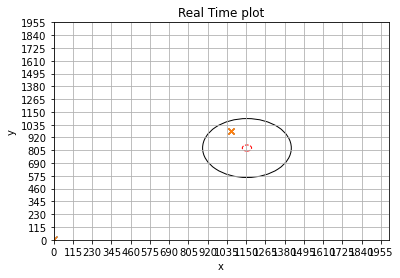

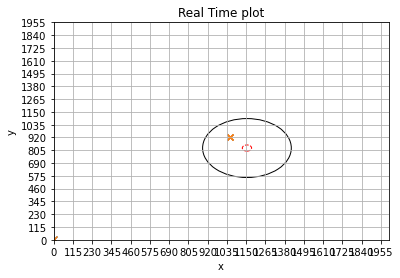

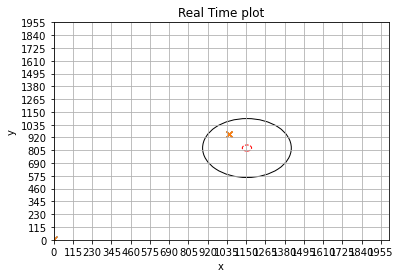

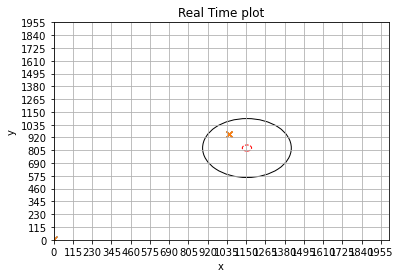

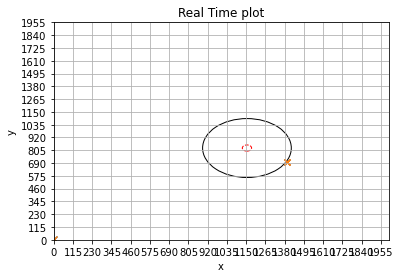

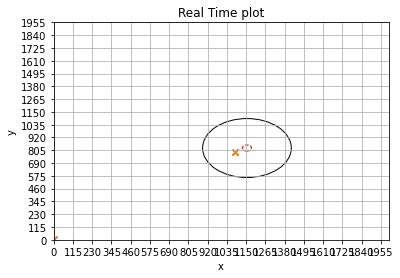

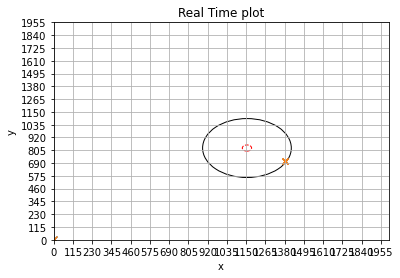

In [5]:
while i <= int(points):
    print('Point #',i)
    
    if i>1:
        moveXY(circle_x-x,circle_y-y) #send the piezo back to the center
    
    #x,y = grab_location(name) #add new location to CSV
    #time.sleep(1)
    
    dx = randxs[i-1] - x #distance to move in each axis
    dy = randys[i-1] - y
    
    dict = {'X (mm)': [randxs[i-1]], 'Y (mm)': [randys[i-1]]} #add the destination point to the CSV every time
    df = pd.DataFrame(dict)
    df.to_csv('.\Results\%s.csv' % fulllist, mode='a', index=False, header=False)
    
    try:
        moveXY(dx,dy) #move toward the destination
    except visa.VisaIOError:
        break
    x,y = grab_location(fulllist) #grab 'final' locaion
    
    if np.sqrt((float(randxs[i-1])-float(x))**2 + (float(randys[i-1])-float(y))**2) <= 0.05: #check if destination reached
        print("Win condition met.")
        i += 1 #go to next point
        n = 1 #reset trial counter
        w += 1
        
        dict = {'X (mm)': [x], 'Y (mm)': [y]} #add win point
        df = pd.DataFrame(dict)
        df.to_csv('.\Results\%s.csv' % winlist, mode='a', index=False, header=False)
    else:
        print('Trying this point again...Trial #',n) #else attempt point again
        n += 1 #increase trial count
    
    if n > int(trials):
        print('Try limit reached. Moving on to the next point...') #unless trial limit reached, move on to next point
        n = 1 #reset trial counter
        i += 1 #go to next point
    
else:
    print('AutoTest complete.') #end after all points attempted

In [ ]:
print('Final win count:',w,'/',points)
